In [11]:
from __future__ import print_function
import numpy as np
import pandas as pd
import gzip,os
from scipy.misc import imread
from tqdm import tqdm_notebook as tq
from IPython.core.display import HTML, display
from matplotlib import pyplot as plt
%matplotlib inline
# this is a neat trick to make the notebook use the full width of the window
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# parameter and directory setup
colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
# folder with all the WoS category data
category_data_dir = 'P:/Projects/WoS/parsed/subjects/'
d2v_dir = 'P:/Projects/WoS/wos-text-dynamics-data/d2v-wos/'

### Category data loading

In [6]:
# here we build a big dataframe with all the WoS category data, joined with d2v indices of each paper

concat = []
idx=0
for year in tq(range(1991,2016)):
    cats_current = pd.read_table('{}{}.txt.gz'.format(category_data_dir,year),header=None,names=['uid','heading','subheading','categories'])
    cats_current['categories'] = cats_current['categories'].apply(lambda x: x if x is np.nan else x.split('|'))
    cats_current['first_cat'] = cats_current['categories'].apply(lambda x: x if x is np.nan else x[0])
    uids = []
    indices = []
    for line in gzip.open('{}uid_indices/{}.txt.gz'.format(d2v_dir,year)):
        uids.append(line.strip().decode('utf8'))
        indices.append(idx)
        idx+=1
    current = cats_current.merge(pd.DataFrame({'uid':uids,'idx':indices}),how='inner',on='uid')
    current['year'] = year
    concat.append(current)
concat = pd.concat(concat)
concat.head()

uid               heading                   subheading  \
0  WOS:A1991FJ25400014  Science & Technology  Life Sciences & Biomedicine   
1  WOS:A1991GH89200009  Science & Technology            Physical Sciences   
2  WOS:A1991EU65600003  Science & Technology  Life Sciences & Biomedicine   
3  WOS:A1991GF28300001       Social Sciences  Life Sciences & Biomedicine   
4  WOS:A1991FK34400017  Science & Technology                   Technology   

                                          categories  \
0  [Environmental Sciences, Limnology, Marine & F...   
1       [Chemistry, Analytical, Chemistry, Physical]   
2                                         [Oncology]   
3  [Psychology, Developmental, Pediatrics, Psychi...   
4  [Instruments & Instrumentation, Physics, Applied]   

                       first_cat  idx  year  
0         Environmental Sciences    0  1991  
1          Chemistry, Analytical    1  1991  
2                       Oncology    2  1991  
3      Psychology, Developmental    3  1991  
4  Instruments & Instrumentation    4  1991

In [7]:
# Now we load the oecd data, and join it with our main dataframe

#### this code block loaded the original oecd excel spreadsheet, but this has been saved to a pandas dataframe. No need to run it:
"""
oecd = pd.read_excel('../WoS/data/oecd.xlsx')
oecd.to_csv('../WoS/data/oecd.csv',index=False)
oecd = oecd.groupby('WoS_Description').apply(lambda df: pd.Series({'level1':df.iloc[0].Description,'level2':df.iloc[1].Description})).reset_index()
oecd['WoS_Description'] = oecd['WoS_Description'].str.title()
oecd.columns = ['first_cat','oecd_1','oecd_2']
oecd.to_pickle(d2v_dir+'oecd.pkl')
"""

oecd = pd.read_pickle(d2v_dir+'oecd.pkl')
concat = concat.merge(oecd,on='first_cat')
concat.head()

uid               heading                   subheading  \
0  WOS:A1991FJ25400014  Science & Technology  Life Sciences & Biomedicine   
1  WOS:A1991GV45700018  Science & Technology  Life Sciences & Biomedicine   
2  WOS:A1991GF13000011  Science & Technology  Life Sciences & Biomedicine   
3  WOS:A1991GU49100003  Science & Technology  Life Sciences & Biomedicine   
4  WOS:A1991GD12600004  Science & Technology  Life Sciences & Biomedicine   

                                          categories               first_cat  \
0  [Environmental Sciences, Limnology, Marine & F...  Environmental Sciences   
1                           [Environmental Sciences]  Environmental Sciences   
2  [Environmental Sciences, Geography, Physical, ...  Environmental Sciences   
3  [Environmental Sciences, Remote Sensing, Imagi...  Environmental Sciences   
4  [Environmental Sciences, Public, Environmental...  Environmental Sciences   

   idx  year              oecd_1  \
0    0  1991  1 NATURAL SCIENCES   
1  151  1991  1 NATURAL SCIENCES   
2  163  1991  1 NATURAL SCIENCES   
3  261  1991  1 NATURAL SCIENCES   
4  328  1991  1 NATURAL SCIENCES   

                                          oecd_2  
0  1.05 Earth and related environmental sciences  
1  1.05 Earth and related environmental sciences  
2  1.05 Earth and related environmental sciences  
3  1.05 Earth and related environmental sciences  
4  1.05 Earth and related environmental sciences

###  Datashader setup

In [10]:
# specify the background color and image size
plot_width  = int(900)
plot_height = int(900)
background = "black"

# some datashader-specific imports and custom functions adapted from this tutorial:
# https://www.continuum.io/blog/developer-blog/analyzing-and-visualizing-big-data-interactively-your-laptop-datashading-2010-us
from functools import partial
import datashader as ds
from datashader
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [30]:
# here we specify the model parameters so we can load the proper data
params = '100-5-5-0.001-None'

# and we'll print out the possible files to load
options = [f for f in os.listdir(d2v_dir+params) if 'lv_coords' in f]
print(options)

# change this line (based on `options`) to choose which coordinates file you want to use
coords_file = 'doc_features_normed_100-5-5-0.001-None.7000000.lv_coords'

['doc_features_normed_100-5-5-0.001-None.1000000.lv_coords', 'doc_features_normed_100-5-5-0.001-None.3000000.lv_coords', 'doc_features_normed_100-5-5-0.001-None.5000000.lv_coords', 'doc_features_normed_100-5-5-0.001-None.7000000.lv_coords']


In [26]:
coords_file.rsplit('.',2)[0]+

'doc_features_normed_100-5-5-0.001-None.7M.lv_coords'

In [33]:
# load the coords file into a dataframe (skipping the first metadata row)
data = pd.read_table('{}{}/{}'.format(d2v_dir,params,coords_file),names=['x','y'],sep=' ',skiprows=1)

# now load the corresponding index file (i.e. which d2v indexes we've actually generated the 2D embedding for)
# there's a bit of logic to make sure we get the right file
sample_size = coords_file.rsplit('.',2)[-2]
if sample_size != 'None':
    if coords_file.rsplit('.')[-1]=='lv_coords':
        index_file = '{}.indices_{}.npy'.format(coords_file.rsplit('.',2)[0],sample_size)
    elif coords_file.rsplit('.')[-1]=='year_lv_coords':
        index_file = '{}.indices_year_{}.npy'.format(coords_file.rsplit('.',2)[0],sample_size)
    indices = np.load('{}{}/{}'.format(d2v_dir,params,index_file))
    data.index = indices


### Plotting with no metadata

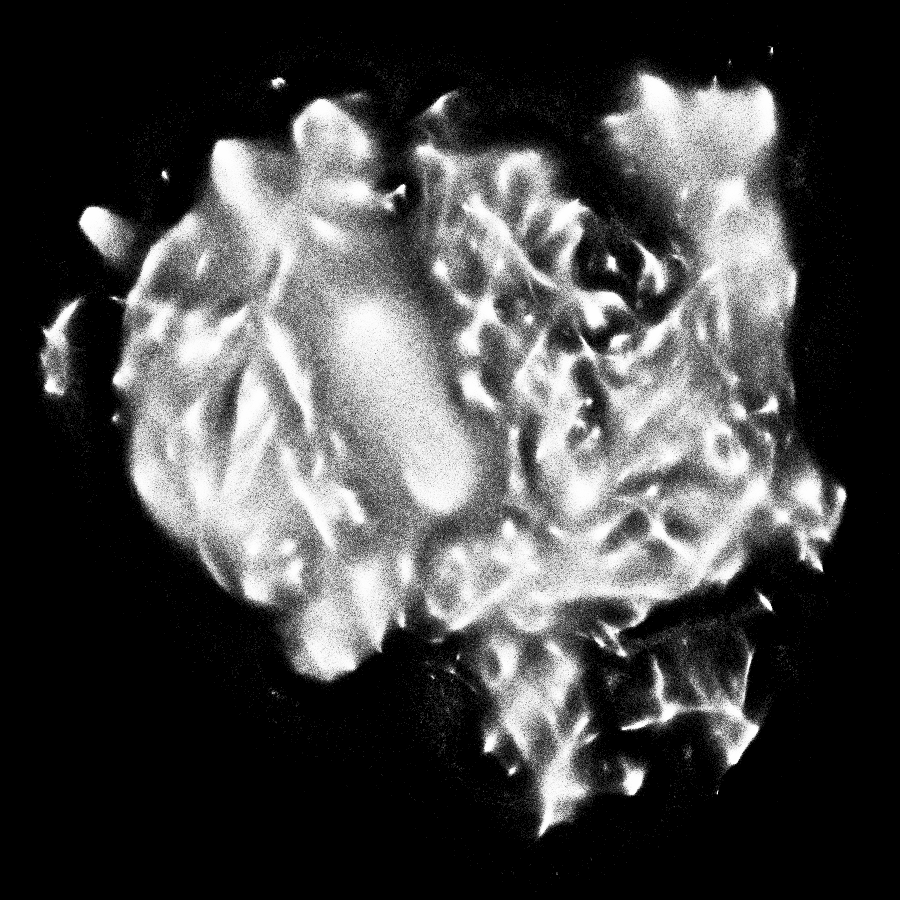

In [39]:
# this will just plot the raw coordinate data
# note that canvas also accepts and x_range and y_range argument if you want to adjust that
cvs = ds.Canvas(plot_width,plot_height)
agg = cvs.points(data, 'x', 'y')
export(tf.shade(agg, cmap = cm(Greys9), how='eq_hist'),"tempfile")


### Coloring by category label

In [42]:
# now we join the coordinate data with the category dataframe
plot_data = concat.join(data,on='idx')
plot_data.head()

uid               heading                   subheading  \
0  WOS:A1991FJ25400014  Science & Technology  Life Sciences & Biomedicine   
1  WOS:A1991GV45700018  Science & Technology  Life Sciences & Biomedicine   
2  WOS:A1991GF13000011  Science & Technology  Life Sciences & Biomedicine   
3  WOS:A1991GU49100003  Science & Technology  Life Sciences & Biomedicine   
4  WOS:A1991GD12600004  Science & Technology  Life Sciences & Biomedicine   

                                          categories               first_cat  \
0  [Environmental Sciences, Limnology, Marine & F...  Environmental Sciences   
1                           [Environmental Sciences]  Environmental Sciences   
2  [Environmental Sciences, Geography, Physical, ...  Environmental Sciences   
3  [Environmental Sciences, Remote Sensing, Imagi...  Environmental Sciences   
4  [Environmental Sciences, Public, Environmental...  Environmental Sciences   

   idx  year              oecd_1  \
0    0  1991  1 NATURAL SCIENCES   
1  151  1991  1 NATURAL SCIENCES   
2  163  1991  1 NATURAL SCIENCES   
3  261  1991  1 NATURAL SCIENCES   
4  328  1991  1 NATURAL SCIENCES   

                                          oecd_2          x          y  
0  1.05 Earth and related environmental sciences   3.054527   5.919164  
1  1.05 Earth and related environmental sciences -11.818069  -0.525485  
2  1.05 Earth and related environmental sciences  -4.972352  13.284440  
3  1.05 Earth and related environmental sciences  -8.536468   3.637272  
4  1.05 Earth and related environmental sciences        NaN        NaN

In [60]:
# because there are subheadings for the science/technology heading, but not for the social sciences or arts/humantities headings, 
# I'm going to make a new combined_subheading column 
plot_data['combined_subheading'] = np.where(plot_data.heading.isin(['Science & Technology']),plot_data.subheading,plot_data.heading)

In [43]:
# here I'm going to set the x range and y_range to just be the xy limits of the data, but you could modify this
xr = (plot_data.x.min(),plot_data.x.max())
yr = (plot_data.y.min(),plot_data.y.max())
xr,yr

((-31.232225, 21.456213000000002), (-23.323043999999999, 20.790801999999999))

In [77]:
# Now I'll define a custom plotting function that we'll use to generate our visuals
"""
To use this, we specify the following:
target_col (required,all other arguments optional) - this is the column specify the categories we want to color by
custom_colors - provide if you want to specify your own colors instead of the defaults
topN - only plot the topN most common unique values of target_col (this must be <= the number of colors in your color key, default 10)
limitcol/ limitval - before plotting, limit the data to documents for which limitcol = limitval
year - limit to papers published this year

This may seem confusing, so there are examples in the cells below
"""
def create_image(target_col,x_range=xr, y_range=yr, w=plot_width, h=plot_height,custom_colors=None,topN=None,limitcol=None,limitval=None,year=None):
    colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
    
    if limitcol is not None:
        df = plot_data[plot_data[limitcol]==limitval]
    else:
        df = plot_data
    
    if topN is not None:
        topN = df[target_col].value_counts().dropna()[:topN].index.values
        df = df[df[target_col].isin(topN)]
    else:
        df = plot_data
    
    if year is not None:
        df = df[df.year==year]
    
    # drop any na values of the target column
    df = df.dropna(subset=[target_col])
        
    # large vis requires that this columns be categorical 
    df['plot_col'] = df[target_col].astype('category')
    
    unique_values = df['plot_col'].unique()
    if custom_colors is None:
        color_key = {val:color for val,color in zip(unique_values,colors)}  
    else:
        color_key = {val:color for val,color in zip(unique_values,custom_colors)} 
        
    # this generates the actual image, colored by category
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('plot_col'))
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    export(img,'temp')
    
    # to create a key, we must save the raster image, then load it into a matplotlib
    # figure, then draw the legend on that
    fig,ax = plt.subplots(1,1,figsize=(12,12))
    img = imread('export/temp.png')
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid()

    for cat in sorted(color_key.keys()):
        legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=25, label=cat, color=color_key[cat],lw=1)
    leg = ax.legend(loc='lower left',ncol=1,fontsize='large',framealpha=0)
    for t in leg.get_texts():
        t.set_color('white')
        
    del df['plot_col']



U:\Users\jjl2228\Anaconda\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


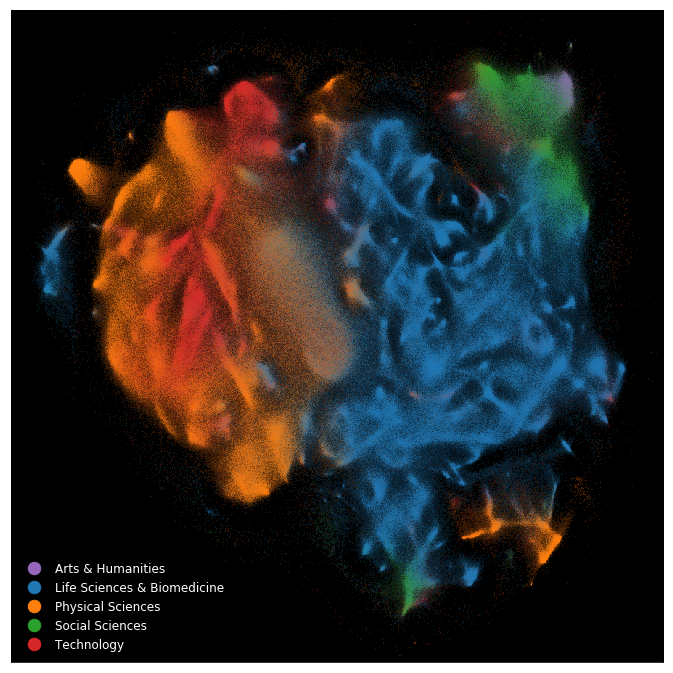

In [80]:
# example 1: plot all documents, colored by combined_subheading
create_image('combined_subheading')


U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


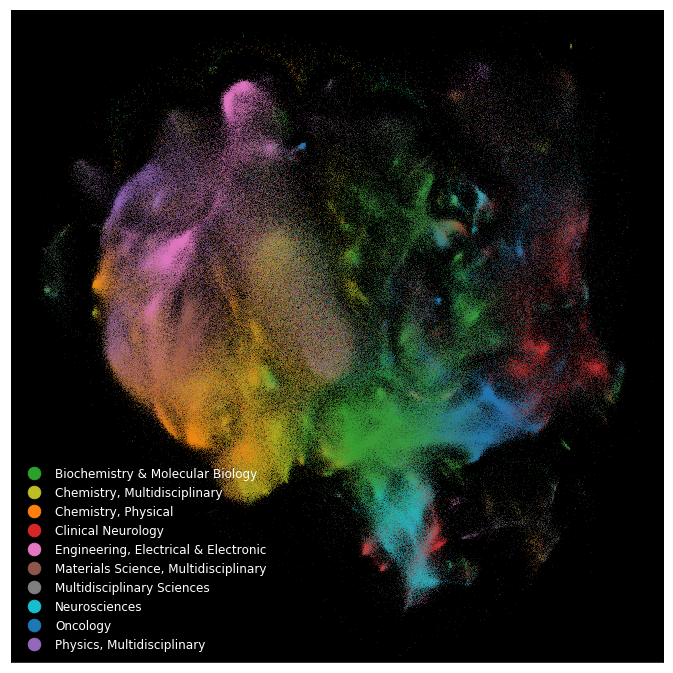

In [79]:
# example 2: plot all documents, colored by the first category listed for the document
# because we have more unique categories than colors, we only plot the top 10 most 
# frequent first_cat values (hence the use of `topN`)
create_image('first_cat',topN=10)


U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: Run

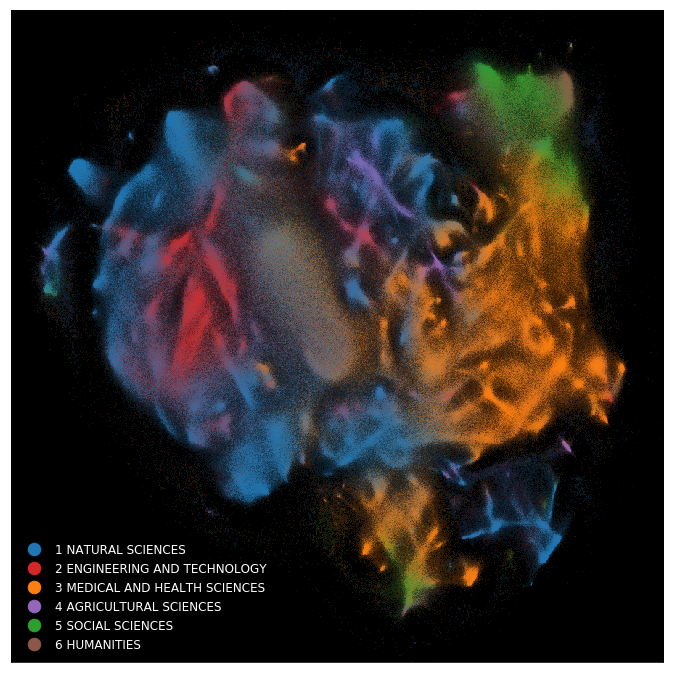

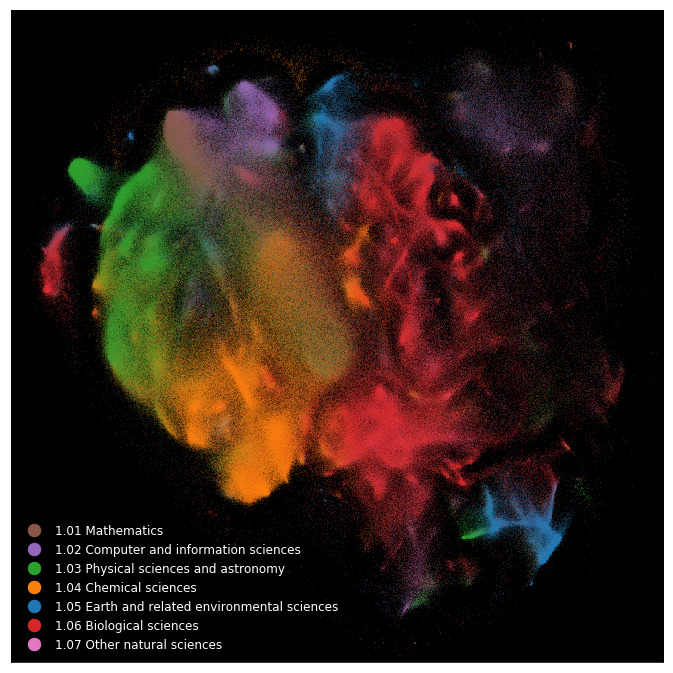

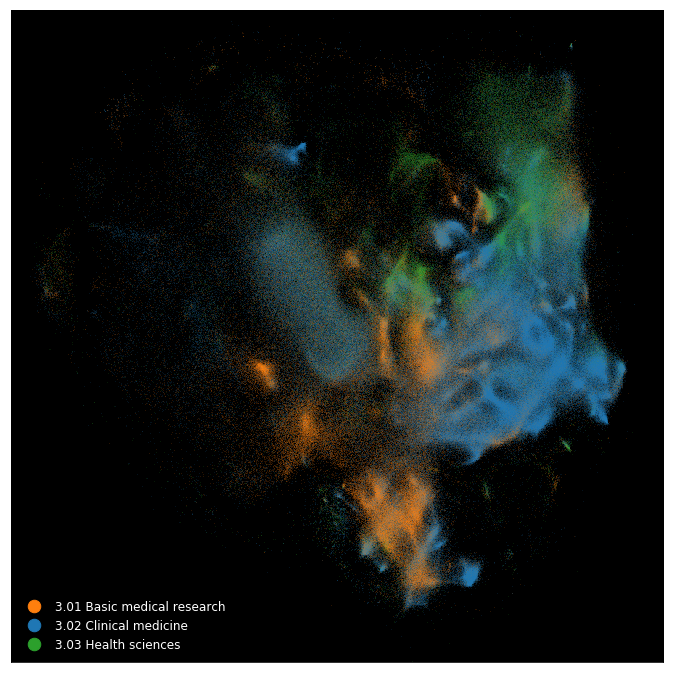

In [82]:
# examples 3 - 5
# let's start by coloring by top-level oecd category
create_image('oecd_1',topN=10)
# now let's say we want to plot by the second-level oecd category, but limiting to cases where the top-level cateogry is 'natural sciences'
create_image('oecd_2',topN=10,limitcol='oecd_1',limitval='1 NATURAL SCIENCES')
# similarly, we can plot sub categories of `medical and health sciences' 
create_image('oecd_2',topN=10,limitcol='oecd_1',limitval='3 MEDICAL AND HEALTH SCIENCES')